In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, recall_score

from sklearn import svm
from sklearn.svm import LinearSVC

from sklearn.dummy import DummyClassifier


from wordcloud import WordCloud, STOPWORDS

import string
from matplotlib import style

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#reading in cleand data with all headlines and engineered features 
#punctuation, non-alphabetical/non-numerical characters removed and links were scrubbed from the data
#numbers were not removed due to prevalence of numbers in clickbait headlines

df = pd.read_csv('../data/with_engineeredfeat_data.csv',index_col=0)

In [4]:
df.shape

(52127, 6)

In [4]:
#Create stopwords list
stopwords_list = stopwords.words('english')

features = df.drop(columns='class')
y = df['class']

#classes are mostly balanced
y.value_counts(normalize=True)

1    0.519309
0    0.480691
Name: class, dtype: float64

## Setting up for modeling
- applying TFIDF transformation to headline text
- train/test split
- creating function for results

In [5]:
#first splitting data for test/train sets 
#ngram range -> unigrams and bigrams 

X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=20)

tfidf = TfidfVectorizer(stop_words = stopwords_list,ngram_range = (1,2))
tfidf_text_train = tfidf.fit_transform(X_train['text'])
tfidf_text_test = tfidf.transform(X_test['text'])

X_train_ef = X_train.drop(columns='text')
X_test_ef = X_test.drop(columns='text')

In [10]:
dump(tfidf,open('tfidf.pkl','wb'))

In [6]:
#combine tf-idf vectors with the engineered features and store as sparse arrays
from scipy import sparse

X_train = sparse.hstack([X_train_ef, tfidf_text_train]).tocsr()
X_test = sparse.hstack([X_test_ef, tfidf_text_test]).tocsr()



In [14]:
X_train_ef

,question,exclamation,starts_with_num,headline_words
19538,0,0,0,16
28029,0,0,0,10
3376,0,0,0,16
33958,0,0,0,9
48840,0,0,0,10
...,...,...,...,...
23497,1,0,0,8
23820,0,0,1,12
37180,0,0,0,14
27143,1,0,0,11


In [9]:
X_test.shape

(13032, 203136)

In [7]:
#creating a function to call after each model iteration to print accuracy and recall scores for test and train
def train_results(preds):
    return "Training Accuracy:", accuracy_score(y_train,preds)," Training Recall:", recall_score(y_train,preds)

def test_results(preds):
    return "Testing Accuracy:", accuracy_score(y_test,preds)," Testing Recall:", recall_score(y_test,preds)

### Dummy Classifier

In [273]:
#baseline model to predict majority class
dc_classifier = DummyClassifier(strategy='most_frequent')

dc_classifier.fit(X_train, y_train)

dc_train_preds = dc_classifier.predict(X_train)
dc_test_preds = dc_classifier.predict(X_test)

print(train_results(dc_train_preds))
print(test_results(dc_test_preds))

('Training Accuracy:', 0.5179946284691137, ' Training Recall:', 1.0)
('Testing Accuracy:', 0.5232504604051565, ' Testing Recall:', 1.0)


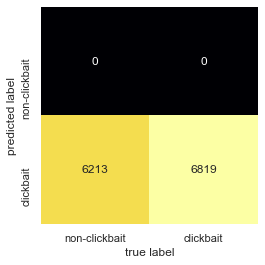

In [274]:
#confusion matrix on test set Dummy Classifier
sns.set()

cm_dc = confusion_matrix(y_test, dc_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### Naive Bayes 

In [8]:
nb_classifier = MultinomialNB(alpha = .05)

nb_classifier.fit(X_train, y_train)

nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

print(train_results(nb_train_preds))
print(test_results(nb_test_preds))

('Training Accuracy:', 0.9986699066376774, ' Training Recall:', 0.9992099155597255)
('Testing Accuracy:', 0.9300184162062615, ' Testing Recall:', 0.9416336706261915)


In [9]:
from pickle import dump

dump(nb_classifier,open('nbmodel.pkl','wb'))

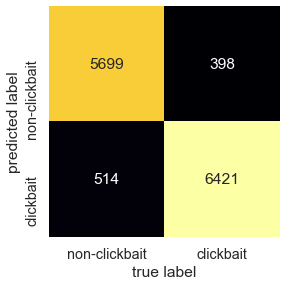

In [19]:
#confusion matrix on test set NB Classifier
sns.set()

cm_dc = confusion_matrix(y_test, nb_test_preds)
sns.set(font_scale=1.3)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.tight_layout()
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('nbcm5')
plt.show();

### Random Forest Classifier 

In [223]:
#rf_classifier = RandomForestClassifier(class_weight = 'balanced', n_estimators = 900 )
rf_classifier = RandomForestClassifier(class_weight = 'balanced' )
rf_classifier.fit(X_train, y_train)

rf_test_preds = rf_classifier.predict(X_test)
rf_train_preds = rf_classifier.predict(X_train)

print(train_results(rf_train_preds))
print(test_results(rf_test_preds))

('Training Accuracy:', 1.0, ' Training Recall:', 1.0)
('Testing Accuracy:', 0.906000613873542, ' Testing Recall:', 0.9325414283619299)


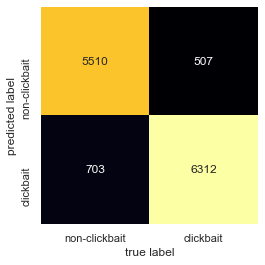

In [73]:
#confusion matrix on test set RFC Classifier (no grid search)
sns.set()

cm_dc = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

In [81]:
#RFC is slightly overfitting, re-running with Gridsearch 
from sklearn.model_selection import GridSearchCV

rfc_grid = RandomForestClassifier(class_weight='balanced')

param_grid_rfc={
    'max_depth': [200,300],
    'n_estimators': [800,900],
}

In [82]:
grid_rfc=GridSearchCV(rfc_grid,param_grid_rfc,cv=2,scoring='accuracy',n_jobs=-1,verbose=1)
grid_rfc.fit(X_train,y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 21.6min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [83]:
#function to get best model stats after running gridsearch
def examinebestmodel(model_name):
    print(model_name.best_score_)
    print(model_name.best_params_)
    print(model_name.best_estimator_)
examinebestmodel(grid_rfc)

0.8902161780472577
{'max_depth': 300, 'n_estimators': 900}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=300, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [84]:
rf_g_test_preds=grid_rfc.best_estimator_.predict(X_test)
rf_g_train_preds=grid_rfc.best_estimator_.predict(X_train)


print(train_results(rf_g_train_preds))
print(test_results(rf_g_test_preds))

('Training Accuracy:', 0.9722215117022637, ' Training Recall:', 0.9474593847217422)
('Testing Accuracy:', 0.9014732965009208, ' Testing Recall:', 0.9029183164686905)


### SVM

('Training Accuracy:', 0.999872106407469, ' Training Recall:', 0.9997530986124142)
('Testing Accuracy:', 0.9323204419889503, ' Testing Recall:', 0.9260888693356797)


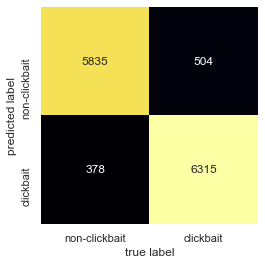

In [242]:
#SVM Model
#svm_classifier = svm.SVC(kernel = 'linear', decision_function_shape='ovo')
svm_classifier = LinearSVC(class_weight='balanced', C=10, max_iter = 1500 )

svm_classifier.fit(X_train, y_train)

svm_test_preds = svm_classifier.predict(X_test)
svm_train_preds = svm_classifier.predict(X_train)

print(train_results(svm_train_preds))
print(test_results(svm_test_preds))

#confusion matrix on test set SVM Classifier 
sns.set()

cm_dc = confusion_matrix(y_test, svm_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### Logistic Regression

('Training Accuracy:', 0.999872106407469, ' Training Recall:', 0.9997530986124142)
('Testing Accuracy:', 0.9310159607120934, ' Testing Recall:', 0.9241824314415603)


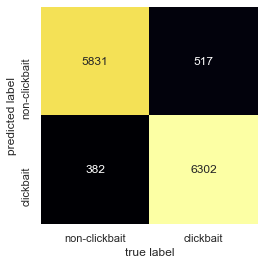

In [270]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=500, class_weight = 'balanced', solver = 'liblinear', tol=0.0001)

lr.fit(X_train,y_train)

lr_train_preds = lr.predict(X_train)
lr_test_preds = lr.predict(X_test)

print(train_results(lr_train_preds))
print(test_results(lr_test_preds))

#confusion matrix on test set lr Classifier 
sns.set()

cm_dc = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### XGBoost

('Testing Accuracy:', 0.8566605279312461, ' Testing Recall:', 0.8558439653908197)
('Training Accuracy:', 0.8834122010487274, ' Training Recall:', 0.8654387437657399)


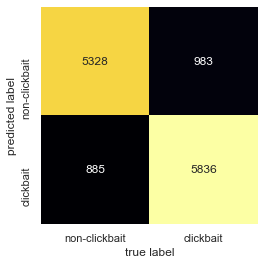

In [272]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_test_preds = xgb_clf.predict(X_test)
xgb_train_preds = xgb_clf.predict(X_train)

#print(train_results(lr_train_preds))
print(test_results(xgb_test_preds))
print(train_results(xgb_train_preds))
#confusion matrix on test set xgboost Classifier 
sns.set()

cm_dc = confusion_matrix(y_test, xgb_test_preds)
sns.heatmap(cm_dc.T, square=True, annot=True, fmt='d', cbar=False,cmap="inferno", xticklabels=['non-clickbait','clickbait'],yticklabels=['non-clickbait','clickbait']
            )
plt.xlabel('true label')
plt.ylabel('predicted label');

### Model Interpretations & Takeaways

In [22]:
#NB coefficients
#creating dataframe for NB coefficients to evaluate the highest/lowest coefficients
coef_nb_2 = pd.DataFrame(nb_classifier.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_nb=coef_nb_2.T

In [29]:
#creating column for feat names
#run cells below first
coef_df_nb['tokens']=all_feat_names_2

In [388]:
nb_classifier.coef_[0]

array([ -4.85421498,  -6.82571707,  -3.99700457, ..., -15.68237801,
       -15.68237801, -15.68237801])

In [25]:
#creating EF name list
engf_name_list=list(X_train_ef.columns)

In [405]:
engf_name_list

['question', 'exclamation', 'starts_with_num', 'headline_words']

In [390]:
len(tfidf.get_feature_names())

203132

In [406]:
all_feat_names_2

[]

In [24]:
#creating all feature names list with engineered features and tfidf names
all_feat_names_2 = []
# all_feat_names.append(ef_name_list)
# all_feat_names.append(tfidf.get_feature_names())

In [26]:
for i in engf_name_list:
    all_feat_names_2.append(i)

In [27]:
for i in tfidf.get_feature_names():
    all_feat_names_2.append(i)

In [28]:
len(all_feat_names_2)

203136

In [30]:
coef_df_nb.set_index('tokens',inplace=True)
coef_df_nb.columns

Index([0], dtype='object')

In [73]:
coef_df_nb.sort_values(by=0,ascending=False).head(15)

,0
tokens,
headline_words,-0.321857
starts_with_num,-3.997005
question,-4.854215
exclamation,-6.825717
people,-7.553511
things,-7.576594
know,-7.775201
make,-7.937052
17,-8.061002


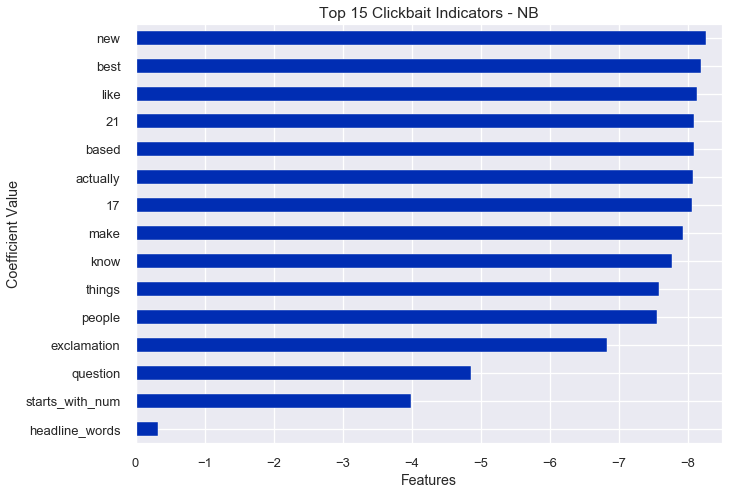

In [78]:
#negative coefficients for non-clickbait
plt.style.use('seaborn-talk')


coef_df_nb[0].sort_values(ascending=False).head(15).plot(kind='barh',color='#002db3')
plt.title("Top 15 Clickbait Indicators - NB")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xlim(0, -8.5)
plt.tight_layout()
plt.savefig('CB_coefs_nb')
plt.show()

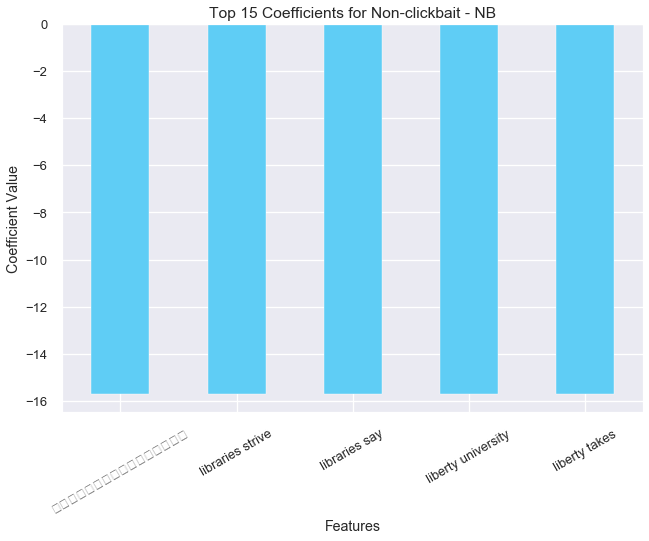

In [417]:
plt.style.use('seaborn-talk')
coef_df_nb[0].sort_values(ascending=True).head().plot(kind='bar',color='#5fcdf5')
plt.title("Top 15 Coefficients for Non-clickbait - NB")
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=30)
plt.show()

### SVM coefficients

In [398]:
#SVM interpretations 


#svm coefficients
#creating dataframe for SVM coefficients to evaluate the highest coefficients
coef_svm = pd.DataFrame(svm_classifier.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_svm=coef_svm.T

In [399]:
coef_df_svm['tokens']=all_feat_names

In [400]:
coef_df_svm.set_index('tokens',inplace=True)

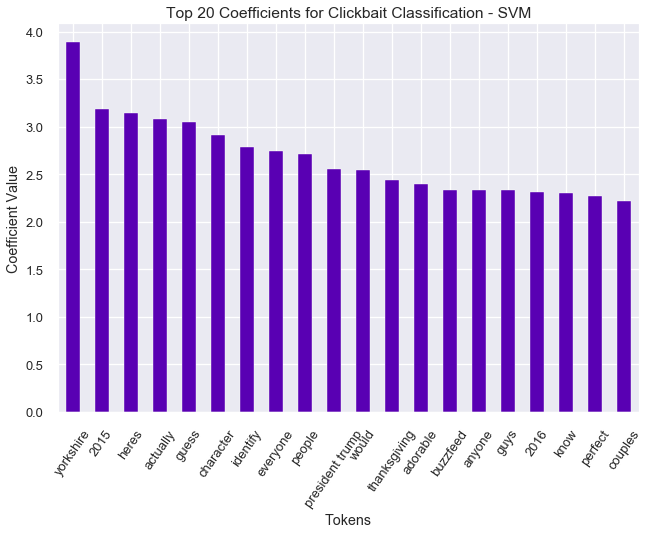

In [401]:
coef_df_svm[0].sort_values(ascending=False).head(20).plot(kind='bar',color='#5900b3')
plt.title("Top 20 Coefficients for Clickbait/Non-Clickbait Classification - SVM")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()

### Logistic Regression coefficients

In [420]:
lr.coef_
#svm coefficients
#creating dataframe for SVM coefficients to evaluate the highest coefficients
coef_lr = pd.DataFrame(lr.coef_)
#coef_svm.sort_values(by=0,ascending=False).head(20)
coef_df_lr=coef_lr.T

In [421]:
coef_df_lr['tokens']=all_feat_names_2

In [422]:
coef_df_lr

,0,tokens
0,1.419063,question
1,6.387158,exclamation
2,4.344563,starts_with_num
3,0.458236,headline_words
4,-0.294248,00
...,...,...
203131,-0.729171,özil
203132,-0.729171,özil omission
203133,-0.316394,śrī
203134,-0.316394,śrī satya


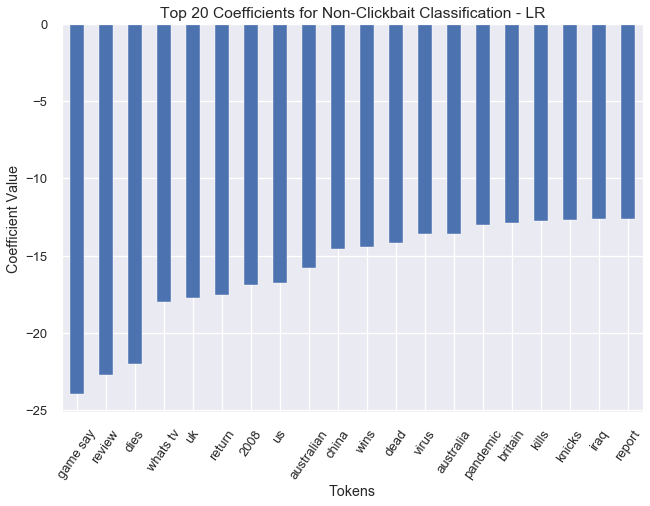

In [430]:
coef_df_lr.set_index('tokens',inplace=True)
coef_df_lr[0].sort_values(ascending=True).head(20).plot(kind='bar')
plt.title("Top 20 Coefficients for Non-Clickbait Classification - LR")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()

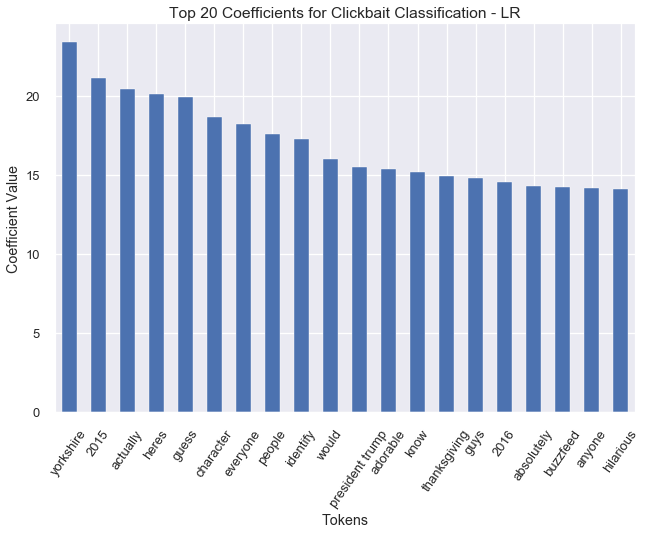

In [431]:
coef_df_lr[0].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title("Top 20 Coefficients for Clickbait Classification - LR")
plt.xlabel('Tokens')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=55)
plt.show()